In [1]:
#import pystan nevermind no general interpolation function
import pymc3 as pm
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import splat
from scipy import interpolate, integrate
import theano.tensor as tt
from theano.compile.ops import as_op
from scipy.interpolate import griddata
import wisps
import wisps.simulations as wispsim
import theano
import splat.empirical as spe

In [2]:
from tqdm import tqdm_notebook

### Purpose: Create a generative model from fundamental distributions
**Towards a full Bayesian hierchical modelling of UCD mass function**

Rough graphical model
- $\alpha$ ~ Uniform
- M &larr; Powerlaw($\alpha$)
- Age ~ Beta
- Teff &larr; (M, Age)

In [3]:
#modelfile='../splines.stan'
datafile='/users/caganze/desktop/burrows2001.csv'
evolutiomodel=pd.read_csv(datafile)

In [4]:
import astropy.units as u

In [5]:
Rsun=8300.
Zsun=27.
SPGRID=np.arange(0, 100)
AREA=((4.1*385.+626.1)*(u.arcmin**2)).to((u.radian)**2) 
SOLID_ANGLE=((np.sin(np.sqrt(AREA)))**2.0).value
pnts=wisps.OBSERVED_POINTINGS
LBS=np.vstack([[x.coord.galactic.l.radian,x.coord.galactic.b.radian] for x in pnts ])

In [6]:
valuest=evolutiomodel.temperature.values
valueslogg=evolutiomodel.gravity.values
valuesrads=evolutiomodel.radius.values
valueslumn=evolutiomodel.luminosity.values

evolpoints=np.array([evolutiomodel.mass.values, evolutiomodel.age.values]).T

@as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dscalar])
def interpolated_teff(mass, age):
    return griddata(evolpoints, valuest , (mass, age), method='linear')

@as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dscalar])
def interpolated_logg(mass, age):
    return griddata(evolpoints, valueslogg , (mass, age), method='linear')

@as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dscalar])
def interpolated_radius(mass, age):
    return griddata(evolpoints, valuesrads , (mass, age), method='linear')

@as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dscalar])
def interpolated_lumn(mass, age):
    return griddata(evolpoints, valueslumn , (mass, age), method='linear')



In [7]:
from theano.ifelse import ifelse

In [8]:
def logprior(l, b):
        return tt.switch(( abs(b) < 0.35),-np.inf, 0)

def loglike(r, z, d, h):
    return np.log10((d**2)*density_function(r, z, h))

#------------------------------------------
def log_prior_on_the_age(a):
    #no negative ages and no ages greater than the universe
     return tt.switch(((a < 0.) | (a >13. )),-np.inf, 0.)
    
def density_function(r, z, h):
    
    """
    A custom juric density function that only uses numpy arrays for speed
    All units are in pc
    """
    l = 2600. # radial length scale of exponential thin disk 
    zpart=np.exp(-abs(z-Zsun)/h)
    rpart=np.exp(-(r-Rsun)/l)
    return zpart*rpart

def log_mass_function(m, alpha):
    return np.log(m**-alpha)

def chi_square(val, pred):
    #our chisquare
    return -(val-pred)**2

def logp(l, b, r, z, d, h, m, alpha, age):
    return (np.log((d**2)*density_function(r, z, h)))+log_mass_function(m, alpha)+log_prior_on_the_age(age)



In [36]:
with pm.Model() as model:
    
    #velocity paremeters
    v10 = 41.899
    tau1 = 0.001
    beta = 0.307
    
    v10_v = 28.823
    tau_v = 0.715
    beta_v = 0.430
    
    v10_w = 23.381
    tau_w = 0.001
    beta_w = 0.445
    
    k = 74.
    
    #priors on mass function and age
    alpha=pm.Uniform('alpha', lower=0.0, upper=0.99)
    beta=pm.Uniform('beta', lower=0.001, upper=1.)
    
    m=pm.Uniform('m', lower=np.nanmin(burrows.mass.values), upper=0.15, testval=0.005)
    #age=pm.Uniform('age', lower=np.nanmin(burrows.age.values), upper=np.nanmax(burrows.age.values))
    age=pm.Gamma('age', alpha=5., beta=beta)
    
    #interpolations
    teff=pm.Deterministic('teff', interpolated_teff(m, age))  
    logg=pm.Deterministic('logg', interpolated_logg(m, age))  
    #radius=pm.Deterministic('rad', interpolated_radius(m, age)) 
    #lumn=pm.Deterministic('lum', interpolated_lumn(m, age))
    
    #velocities
    sigma_u =pm.Normal('sigma_u',  mu=v10*((age+tau1)/(10.+tau1))**beta, sigma=1., observed=41.)
    uvel =pm.Normal('uvel', mu=0.0, sigma=sigma_u)

    sigma_v = pm.Deterministic('sigma_v', v10_v*((age+tau_v)/(10.+tau_v))**beta_v)
    
    voff = -1.*(sigma_v**2)/k
    vvel = pm.Normal('vvel', mu=voff,sigma=sigma_v)
    
    sigma_w = pm.Deterministic('sigma_w', v10_w*((age+tau_w)/(10.+tau_w))**beta_w)
    wvel = pm.Normal('wvel', mu=0., sigma=sigma_w)

    #galactic structure from velocity dispersion
    sigma_tot=pm.Deterministic('sigma_tot', (sigma_w**2+sigma_u**2+sigma_v**2)**0.5)
    
    h=pm.Normal('h',mu=(217/68)*(sigma_tot**2)/20.0, sigma=50, observed=350.)
    
    l=pm.Uniform('l', lower=-np.pi, upper=np.pi, testval=np.pi/2)
    b=pm.Uniform('b', lower=-np.pi/2, upper=np.pi/2, testval=np.pi/3)
    
    d=pm.Uniform('d', lower=0., upper=5000., testval=500.)
    x=pm.Deterministic('x',  Rsun-d*np.cos(b)*np.cos(l))
    y=pm.Deterministic('y', -d*np.cos(b)*np.sin(l))
    r=pm.Deterministic('r', (x**2+y**2)**0.5 )
    z=pm.Deterministic('z', Zsun+ d * np.sin(b))

    
    #likelihood
    like = pm.DensityDist('likelihood', logp, observed={'l':l, 'b':b,
                         'r': r, 'z': z, 'd':d, 'h':h, 'm':m, 'alpha':alpha, 'age':age})


    trace = pm.sample(draws=1000, cores=4,step=None, init='advi',  start=None, 
                      trace=None, chain_idx=0, chains=None,
                      tune=500, progressbar=True, model=None,
                      random_seed=None, discard_tuned_samples=True, compute_convergence_checks=False)

    
    



Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average Loss = -2.6423:  52%|█████▏    | 103949/200000 [02:16<02:06, 761.54it/s]   
Convergence achieved at 104000
INFO:pymc3.variational.inference:Convergence achieved at 104000
Interrupted at 103,999 [51%]: Average Loss = 0.23548
INFO:pymc3.variational.inference:Interrupted at 103,999 [51%]: Average Loss = 0.23548
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d, b, l, wvel, vvel, uvel, age, m, beta, alpha]
INFO:pymc3:NUTS: [d, b, l, wvel, vvel, uvel, age, m, beta, alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [07:00<00:00, 14.28draws/s]


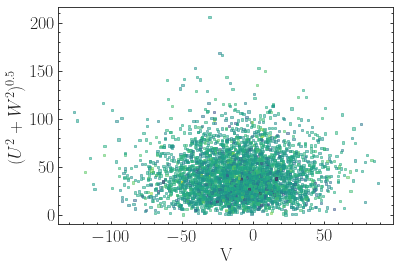

In [37]:
fig, ax=plt.subplots()
c=plt.scatter( trace.vvel,  (trace.uvel**2+trace.wvel**2)**0.5, c=trace.age, s=5., 
              alpha=0.5,marker=",", cmap='viridis')
ax.set_xlabel('V', fontsize=18)
ax.set_ylabel(r'$(U^2+W^2)^{0.5}$', fontsize=18)
plt.minorticks_on()

In [38]:
kde1=wisps.kernel_density([trace.r, trace.z])
kde2=wisps.kernel_density([trace.x, trace.y])

dens1=kde1.pdf([trace.r, trace.z])
dens2=kde2.pdf([trace.x, trace.y])

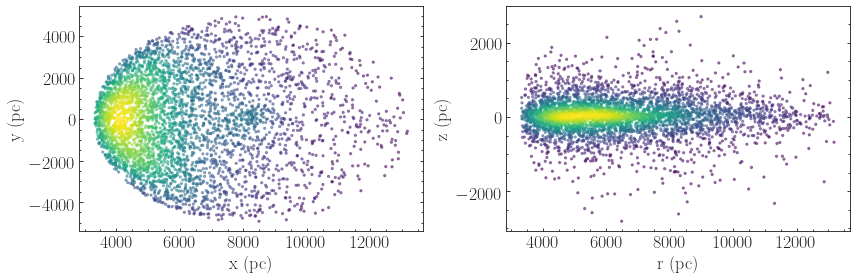

In [39]:
fig, ax=plt.subplots(ncols=2, figsize=(12, 4))
c=ax[0].scatter(trace.x, trace.y,  c=dens2, s=5.,  alpha=0.5, cmap='viridis')
ax[0].set_xlabel('x (pc)', fontsize=18)
ax[0].set_ylabel('y (pc)', fontsize=18)

c=ax[1].scatter(trace.r, trace.z,  c=dens1, s=5.,  alpha=0.5, cmap='viridis')
ax[1].set_xlabel('r (pc)', fontsize=18)
ax[1].set_ylabel('z (pc)', fontsize=18)

ax[0].minorticks_on()
ax[1].minorticks_on()

plt.tight_layout()

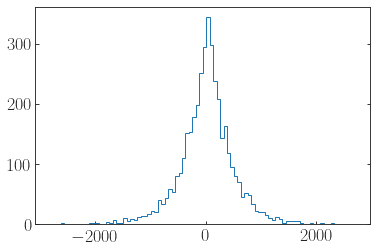

In [40]:
h=plt.hist(trace.z, bins='auto', histtype='step')
#plt.axvline(trace.h.mean(), c='k')

In [41]:
tot_v=(trace.vvel**2+trace.uvel**2+trace.wvel**2)**0.5

In [50]:
df=pd.DataFrame(np.vstack([trace.age, trace.teff, trace.sigma_tot, trace.logg, trace.alpha, trace.beta])).T

In [51]:
samples=df.dropna().values

In [52]:
import corner

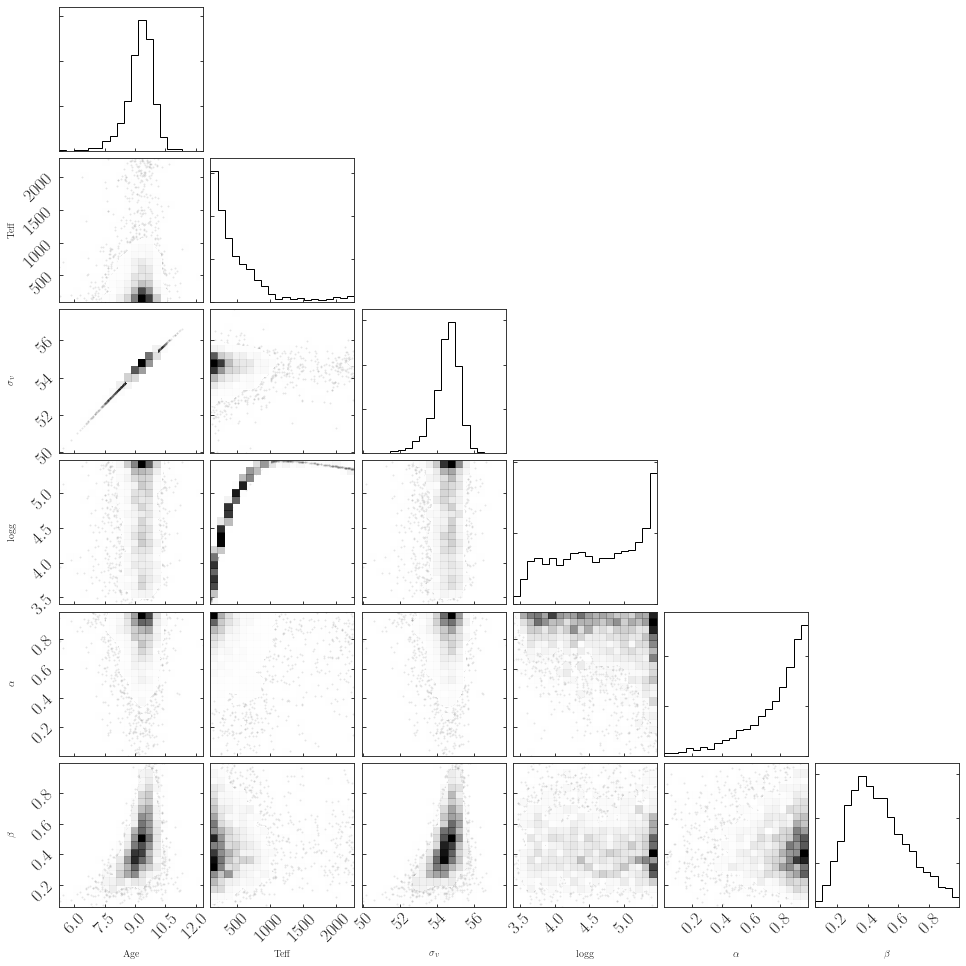

In [53]:
c=corner.corner(samples, plot_contours=False, labels=[ 'Age', 'Teff',  r'$\sigma_v$', 'logg',r'$\alpha$', r'$\beta$'])